In [21]:
%matplotlib inline

In [22]:
# Goes through each step of the HE algorithm

In [23]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pylab

pylab.rcParams['figure.figsize'] = (10.0, 8.0)

In [24]:
#Initialization of image

name = "../Images/HE_image30.tif"
img = cv2.imread(name)

In [25]:
#Convert from BGR to RGB to HSV

b,g,r = cv2.split(img)
rgb_img = cv2.merge([r,g,b])
rg = cv2.merge([r,g,b])
rg = rg.astype(np.float32)

np.seterr(all = 'ignore')
mask = np.empty_like(rg)
arr_max = rg.max(-1)
delta = rg.ptp(-1)
s = delta/arr_max
s[delta==0]=0
idx = (rg[:,:,0] == arr_max)
mask[idx,0] = np.true_divide((rg[idx,1] - rg[idx,2]), delta[idx])
idx = (rg[:,:,1] == arr_max)
mask[idx,0] = 2. + np.true_divide((rg[idx,2] - rg[idx,0]), delta[idx])
idx = (rg[:,:,2] == arr_max)
mask[idx,0] = 4. + np.true_divide((rg[idx,0]-rg[idx,1]), delta[idx])
mask[:,:,0] = ((mask[:,:,0]/6.0)%1.0)*255.0
mask[:,:,0] = np.nan_to_num(mask[:,:,0])
mask[:,:,1] = s * 255.0
mask[:,:,2] = arr_max
mask = mask.astype(np.uint8)

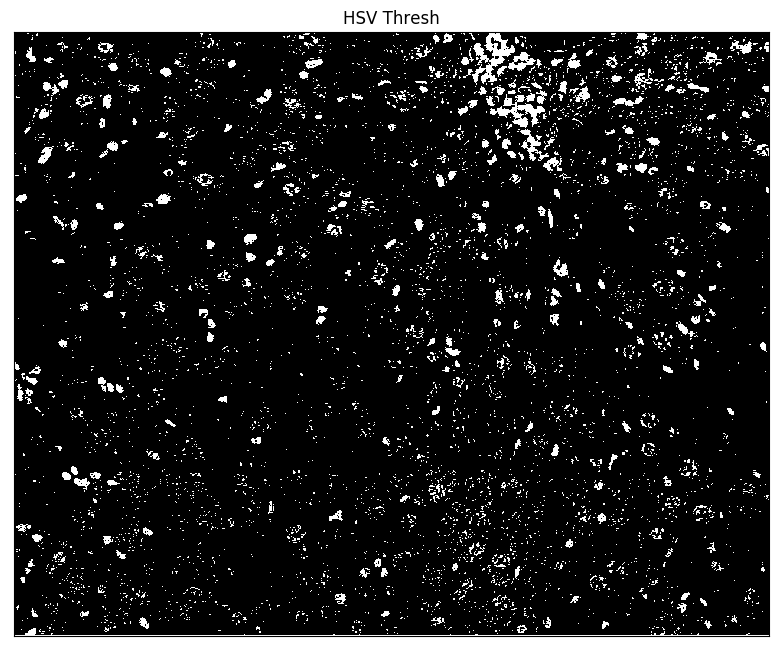

Binary Count: 75322


In [26]:
# Threshold to segment nuclei 

hsv_thresh = cv2.inRange(mask, (120,0,0), (190,255,235))
plt.imshow(hsv_thresh, cmap = 'gray'), plt.title("HSV Thresh"), plt.xticks([]), plt.yticks([]), plt.show()
        
print("Binary Count: {}".format(cv2.countNonZero(hsv_thresh)))

Nuclei Contours: 8279
Binary Count w/ min. area of 50: 40910
Length of Centroids: 247


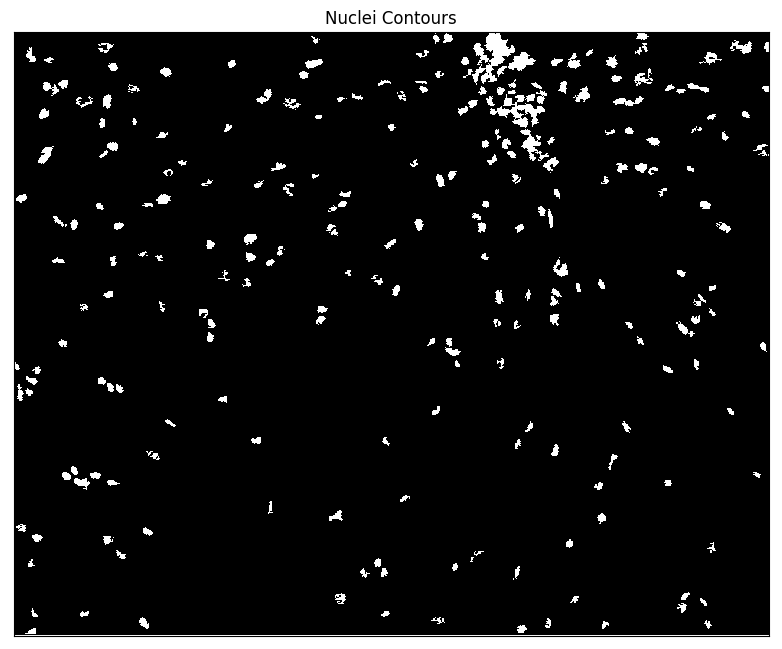

(<matplotlib.image.AxesImage at 0x7852b70>,
 ([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>),
 None)

In [27]:
# Find contours of inflammation cells form inflammation mask
nuclei_cnt, _ = cv2.findContours(hsv_thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
nuclei_img = np.zeros(hsv_thresh.shape, np.uint8)

# Initialize list that will hold centroids
centroid = []
print("Nuclei Contours: {}".format(len(nuclei_cnt)))

#Loop to calculate if cells are large enough to be counted and find centroids of cells and place into list
for c in nuclei_cnt:
    if cv2.contourArea(c) > 50:
        moment = cv2.moments(c)
        #Make sure division by zero doesn't occur
        if moment['m00'] != 0.0:
            cx = moment['m10']/moment['m00']
            cy = moment['m01']/moment['m00']
            #Place centroids into list
            centroid.append((cx,cy))
            cv2.drawContours(nuclei_img, [c], 0, 255, -1)

#Print no. of non-zero pixels after min. area was called
print("Binary Count w/ min. area of 50: {}".format(cv2.countNonZero(nuclei_img)))
cv2.imwrite("contours.tif", nuclei_img)
#Print size of centroids list (How many centroids were found)
print("Length of Centroids: {}".format(len(centroid)))
plt.imshow(nuclei_img, cmap = 'gray'), plt.title("Nuclei Contours"),plt.xticks([]), plt.yticks([]), plt.show()

In [28]:
# Create list of clusters which will indicate no. of clusters in image and how many points per cluster
clusters = []

distance_threshold = 50

# Loop to find distance between all centroids and if close enough, place pairs into list called clusters
for x in range(len(centroid)):
    for y in range(len(centroid)):
        #Find distance between each centroid
        distance = np.sqrt(np.square(centroid[y][0]-centroid[x][0])+np.square(centroid[y][1]-centroid[x][1]))
        #Check that pair is not in list already and meets distance requirement
        if ((centroid[y],centroid[x]) not in clusters) and distance <= distance_threshold:
            clusters.append((centroid[x],centroid[y]))

print("Size of Clusters: {}".format(len(clusters)))

Size of Clusters: 494


In [29]:
#Create a new vector of clusters
lists = {}
a = 0

#Loop to find which centroids belong to which cluster based on neighbors
for x in range(len(clusters)):
    #If lists is empty, start by placing initial pair from clusters into lists
    if len(lists) == 0:
        key = "list_" + str(a)
        lists[key] = []
        lists[key].append(clusters[x][0])
        lists[key].append(clusters[x][1])
        a += 1
    #If lists is not empty, decide which cluster to place based on if pairs or neighbors are in cluster already
    else:
        len_list = -1
        #Check all the clusters and see if any of the pairs have already been designated to a cluster
        for y in list(lists):
            len_list += 1
            #If one of the pairs is in the cluster, add the other centroid of the pair to the cluster
            if clusters[x][0] in lists[y] and clusters[x][1] not in lists[y]:
                lists[y].append(clusters[x][1])
                break
            #If the second centroid in the pair is in cluster but the first is not, add the first centroid to cluster
            elif clusters[x][1] in lists[y] and clusters[x][0] not in lists[y]:
                lists[y].append(clusters[x][0])
                break
            #If both centroids in the pair are in the cluster, no more searching is needed
            elif clusters[x][0] in lists[y] and clusters[x][1] in lists[y]:
                break
            #If the centroids weren't in a cluster and there are no more clusters, create a new cluster and place them into the new cluster
            elif len_list == len(lists)-1:
                key = "list_" + str(a)
                lists[key] = []
                lists[key].append(clusters[x][0])
                a += 1

In [30]:
#Print how many clusters were created from previous loop
print("Current number of clusters: {}".format(len(lists)))
#Print how many cells are within each cluster
print("Number of cells in clusters: ")

cluster_size_threshold = 15

#Check all the clusters for how many points are in them and kick out if under minimum cluster size
#Example: if it only has 2 centroids, it won't count as cluster
for y in list(lists):
    print("\t{}:\t{}".format(y,len(lists[y])))
    if len(lists[y]) < cluster_size_threshold:
        lists.pop(y)

Current number of clusters: 112
Number of cells in clusters: 
	list_68:	2
	list_69:	3
	list_66:	2
	list_67:	3
	list_64:	1
	list_65:	5
	list_62:	1
	list_63:	1
	list_60:	1
	list_61:	2
	list_108:	2
	list_109:	1
	list_104:	1
	list_105:	1
	list_106:	3
	list_107:	1
	list_100:	25
	list_101:	6
	list_102:	11
	list_103:	1
	list_93:	1
	list_92:	1
	list_91:	5
	list_90:	3
	list_97:	5
	list_96:	1
	list_95:	3
	list_94:	1
	list_99:	2
	list_98:	7
	list_19:	1
	list_18:	1
	list_13:	2
	list_12:	1
	list_11:	3
	list_10:	1
	list_17:	1
	list_16:	1
	list_15:	2
	list_14:	3
	list_111:	2
	list_110:	1
	list_80:	2
	list_81:	9
	list_82:	1
	list_83:	1
	list_84:	3
	list_85:	1
	list_86:	6
	list_87:	1
	list_88:	1
	list_89:	1
	list_35:	1
	list_34:	1
	list_37:	1
	list_36:	1
	list_31:	2
	list_30:	1
	list_33:	1
	list_32:	1
	list_39:	5
	list_38:	1
	list_22:	1
	list_23:	1
	list_20:	1
	list_21:	1
	list_26:	4
	list_27:	1
	list_24:	2
	list_25:	1
	list_28:	1
	list_29:	1
	list_57:	1
	list_56:	1
	list_55:	6
	list_54:	2
	list_53:	1


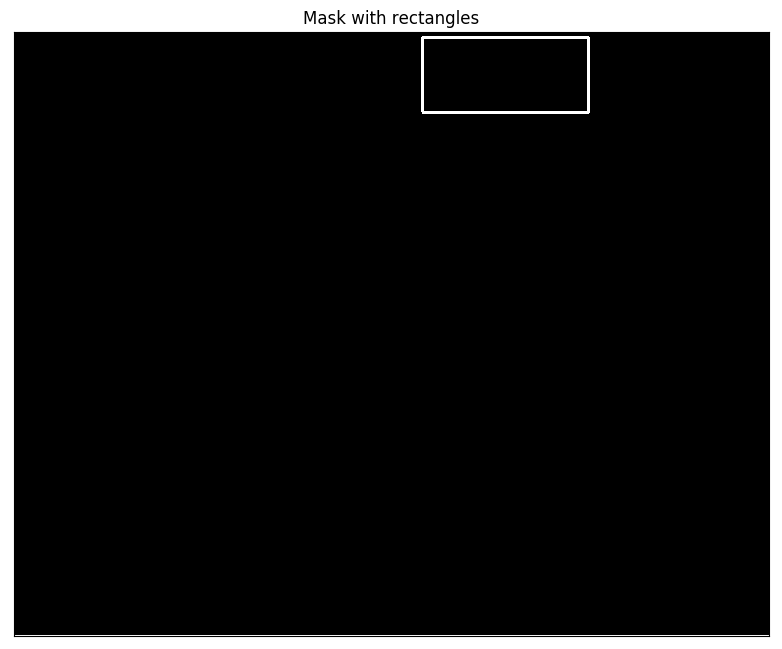

(<matplotlib.image.AxesImage at 0x8084898>,
 ([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>),
 None)

In [31]:
#Create a new black image
rectangle_mask = np.zeros(hsv_thresh.shape, np.uint8)
cluster_results = {}

#Go through lists and identify the cluster size and draw a rectangle around cluster
for y in list(lists):
        topmost = 1280
        bottommost = 0
        leftmost = 1280
        rightmost = 0
        #Finds extreme points of cluster
        for x in range(len(lists[y])):
            if (lists[y][x][0] < leftmost):
                leftmost = int(lists[y][x][0])
            if (lists[y][x][1] < topmost):
                topmost = int(lists[y][x][1])
            if (lists[y][x][0] > rightmost):
                rightmost = int(lists[y][x][0])
            if (lists[y][x][1] > bottommost):
                bottommost = int(lists[y][x][1])
        #Draws rectangle on mask 
        cv2.rectangle(rectangle_mask, (leftmost, bottommost), (rightmost, topmost), 255, 4)
        
plt.imshow(rectangle_mask, cmap = 'gray') , plt.title("Mask with rectangles"), plt.xticks([]), plt.yticks([]), plt.show()

Current clusters: 1


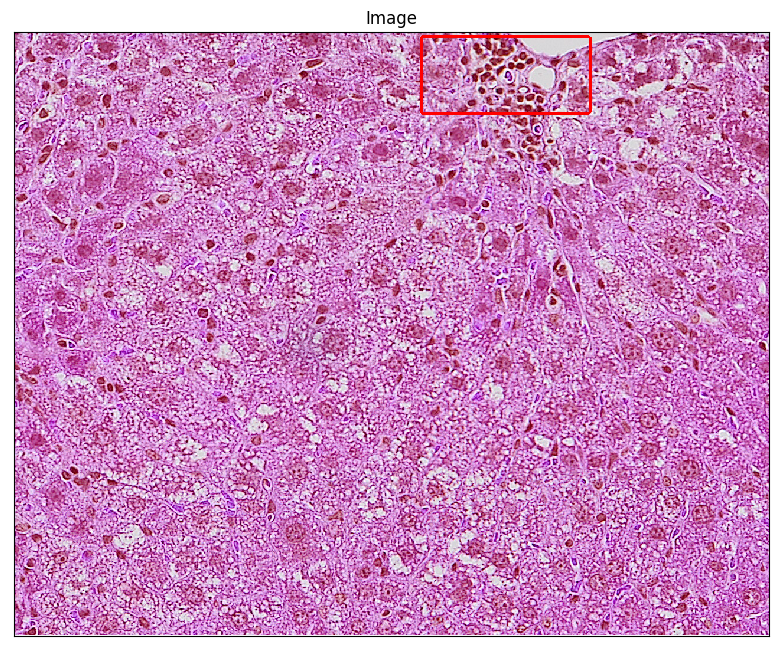

../Images/HE_image30.tif	1	31	37172.0


In [32]:
cluster_results = {}
a = 0 
#Finds contours from mask of rectangles
#Used to detect if rectangles overlap and merge them
rectangle_cnt, _ = cv2.findContours(rectangle_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
for c in rectangle_cnt:
    a +=1
    point_cnt = 0
    cluster_results[a] = []
    #Uses point polygon test to see if centroids are within rectangle
    for i in range(len(centroid)):
        num = cv2.pointPolygonTest(c, centroid[i], False)
        if num == 0 or num == 1:
            point_cnt += 1
    cluster_results[a].append(point_cnt)
    cluster_results[a].append(cv2.contourArea(c))
    #Draws contours onto image
    cv2.drawContours(img, [c], 0, (255,0,0), 4)

print("Current clusters: {}".format(len(rectangle_cnt)))
plt.imshow(img), plt.title("Image"), plt.xticks([]), plt.yticks([]), plt.show()
for a in cluster_results:
    print("{}\t{}\t{}\t{}".format(name,a, str(cluster_results[a][0]), str(cluster_results[a][1])))